In [273]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision import transforms
from torchsummary import summary
import torchvision.models as models
import scipy
from PIL import ImageGrab
import time

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if torch.cuda.is_available():
  torch.set_default_device('cuda')
  device = 'cuda'
else:
  device = 'cpu'

start

In [25]:
cntry_str =  np.load('cntry_str.npy', allow_pickle=True)
cntry_dict = dict(zip(cntry_str, range(len(cntry_str))))
country_codes = {
    'AD': 'Andorra',
    'AE': 'United Arab Emirates',
    'AR': 'Argentina',
    'AU': 'Australia',
    'BD': 'Bangladesh',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'BR': 'Brazil',
    'BT': 'Bhutan',
    'BW': 'Botswana',
    'CA': 'Canada',
    'CH': 'Switzerland',
    'CL': 'Chile',
    'CO': 'Colombia',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GB': 'United Kingdom',
    'GR': 'Greece',
    'HK': 'Hong Kong',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'ID': 'Indonesia',
    'IE': 'Ireland',
    'IL': 'Israel',
    'IS': 'Iceland',
    'IT': 'Italy',
    'JP': 'Japan',
    'KH': 'Cambodia',
    'KR': 'South Korea',
    'LT': 'Lithuania',
    'LV': 'Latvia',
    'MX': 'Mexico',
    'MY': 'Malaysia',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'NZ': 'New Zealand',
    'PE': 'Peru',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'RU': 'Russia',
    'SE': 'Sweden',
    'SG': 'Singapore',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'SZ': 'Eswatini',
    'TH': 'Thailand',
    'TW': 'Taiwan',
    'UA': 'Ukraine',
    'US': 'United States',
    'ZA': 'South Africa'
}

In [ ]:
def visual(loader, n, model=None):
    for images, labels in loader:
        for i in range(n):
            print(f'label: {country_codes[cntry_str[labels[i]]]}')
            if model != None:
                 print(f'guess: {country_codes[cntry_str[torch.argmax(model(images[i][None, :])).item()]]}')
            plt.figure(figsize = (50,2))
            plt.imshow(images[i].to('cpu').transpose(0,2).transpose(0,1) * 0.5 + 0.5)
            plt.show()
        break

In [3]:
fromfile = False
if fromfile:
    df = pd.read_parquet('data', engine='fastparquet')
    shuffled_df = df[['image.bytes', 'country_iso_alpha2']].sample(frac=1)
    shuffled_df.to_parquet('shuffled_data.parquet')
df = pd.read_parquet('shuffled_data.parquet', engine='fastparquet')
df = df[df.country_iso_alpha2.isin(cntry_str)]
rows = df.shape[0]

In [4]:
class ParquetImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(io.BytesIO(row['image.bytes']))
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), np.searchsorted(cntry_str, row['country_iso_alpha2'])

class JpgImageDataset(torch.utils.data.Dataset):
    def __init__(self, lst, transforms=None):
        self.lst = lst
        self.transforms = transforms

    def __len__(self):
        return len(self.lst)

    def __getitem__(self, idx):
        row = self.lst[idx]
        image = Image.open(row[0])
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), row[1]

generator, dataset, dataloader

In [5]:
parquet_dataset = ParquetImageDataset(df, transforms.Compose([transforms.RandomCrop((512, 1187)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

imfolder = torchvision.datasets.ImageFolder.make_dataset(directory="newjpgdata", is_valid_file=(lambda s: Image.open(s).size == (1536, 662)), class_to_idx=cntry_dict)
jpg_dataset = JpgImageDataset(imfolder, transforms=transforms.Compose([transforms.Resize(512), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

big_dataset = torch.utils.data.ConcatDataset([jpg_dataset, parquet_dataset])

# datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [0.7, 0.2, 0.1], generator=torch.Generator('cuda'))

# dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

In [ ]:
data_loader = torch.utils.data.DataLoader(big_dataset, batch_size=32, shuffle=True, num_workers=0, generator=torch.Generator(device=device))
visual(data_loader, 4)

model3

In [252]:
class Model3(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone.fc.parameters():
            param.requires_grad = True
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        self.layer = nn.Linear(1000, 56)
        

    def forward(self, x):
        x = self.backbone(x)
        x = self.layer(x)
        return x


In [253]:
model = Model3().to(device)

In [254]:
optimizer = optim.Adam(model.parameters())

In [255]:
summary(model, (3, 128, 691))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 346]           9,408
       BatchNorm2d-2          [-1, 64, 64, 346]             128
              ReLU-3          [-1, 64, 64, 346]               0
         MaxPool2d-4          [-1, 64, 32, 173]               0
            Conv2d-5          [-1, 64, 32, 173]           4,096
       BatchNorm2d-6          [-1, 64, 32, 173]             128
              ReLU-7          [-1, 64, 32, 173]               0
            Conv2d-8          [-1, 64, 32, 173]          36,864
       BatchNorm2d-9          [-1, 64, 32, 173]             128
             ReLU-10          [-1, 64, 32, 173]               0
           Conv2d-11         [-1, 256, 32, 173]          16,384
      BatchNorm2d-12         [-1, 256, 32, 173]             512
           Conv2d-13         [-1, 256, 32, 173]          16,384
      BatchNorm2d-14         [-1, 256, 

Training

In [256]:

# költségek tárolása, hogy tudjuk majd őket ábrázolni
tr_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()

# tanítás
for epoch in range(30):
  for i, iter in enumerate(train_dataloader):
      
      #print(iter[1])

      # train mode, gradiensek nullázása
      model.train()
      optimizer.zero_grad()

      # backprop, param update
      train_loss = criterion(model(iter[0]), iter[1])  # model.get_loss(iter)
      train_loss.backward()
      optimizer.step()

      if i % 20 == 0:
        tr_losses.append(train_loss.item())
        with torch.no_grad():
            model.eval()
            total_loss = 0.0
            sum = 0; count = 0
            j = 0
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item()

                sum += torch.sum(torch.argmax(outputs, 1) == targets); count += targets.shape[0]
                

                j += 1
                if j > 3:
                  break
            val_loss = total_loss / j
        val_losses.append(val_loss)
        print(f"epoch {epoch}, step {i}: train loss {train_loss:.5f}, val loss: {val_loss:.5f}, val acc: {sum / count:.5f}")

#print(f"epochs: {iter+1}, train loss {train_loss:.2f}, val loss: {val_loss:.2f}")

epoch 0, step 0: train loss 4.05369, val loss: 3.60362, val acc: 0.22656
epoch 0, step 20: train loss 3.16400, val loss: 3.33621, val acc: 0.24219
epoch 0, step 40: train loss 3.63108, val loss: 3.11401, val acc: 0.31250
epoch 0, step 60: train loss 2.68031, val loss: 2.91117, val acc: 0.34375
epoch 0, step 80: train loss 2.56084, val loss: 2.54239, val acc: 0.39844
epoch 0, step 100: train loss 2.82725, val loss: 2.53834, val acc: 0.39062
epoch 0, step 120: train loss 2.17020, val loss: 2.71935, val acc: 0.34375
epoch 0, step 140: train loss 2.42002, val loss: 2.38135, val acc: 0.37500
epoch 0, step 160: train loss 2.18742, val loss: 2.22011, val acc: 0.46875
epoch 0, step 180: train loss 2.91776, val loss: 2.25548, val acc: 0.45312
epoch 0, step 200: train loss 2.45303, val loss: 2.07670, val acc: 0.46875
epoch 0, step 220: train loss 2.72471, val loss: 2.29142, val acc: 0.38281
epoch 0, step 240: train loss 1.75598, val loss: 2.10116, val acc: 0.45312
epoch 0, step 260: train loss 1

KeyboardInterrupt: 

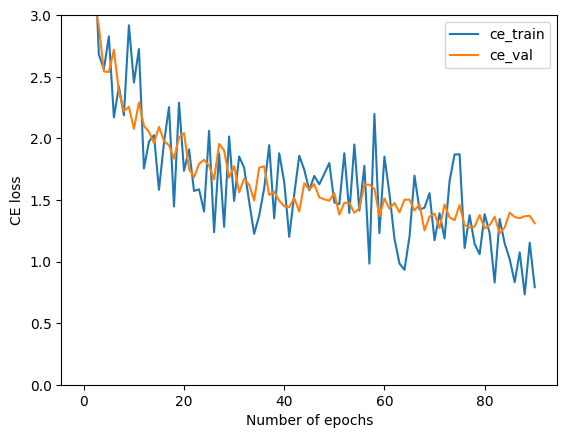

In [257]:
# loss plot
plt.plot(tr_losses, label="ce_train")
plt.plot(val_losses, label="ce_val")
plt.xlabel("Number of epochs")
plt.ylabel("CE loss")
plt.ylim(0,3)
plt.legend()
plt.show()

In [258]:
with torch.no_grad():
    model.eval()
    total_loss = 0.0
    j = 0

    sum = 0
    count = 0
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        sum += torch.sum(torch.argmax(outputs, 1) == targets)
        count += targets.shape[0]

        j += 1
        if j > 60:
            break
    val_loss = total_loss / j
    print(sum / count)

tensor(0.5922, device='cuda:0')


In [ ]:
visual(test_dataloader, 4, model)

In [ ]:
#torch.save(model.state_dict(), "models/alma")

In [ ]:
#model2 = Model3().to(device)
#model2.load_state_dict(torch.load("models/rn151hq"))
#model2.eval()

In [ ]:
l = np.zeros(56)
for x in jpg_dataset:
    l[x[1]] += 1
for x in parquet_dataset:
    l[x[1]] += 1

<BarContainer object of 56 artists>

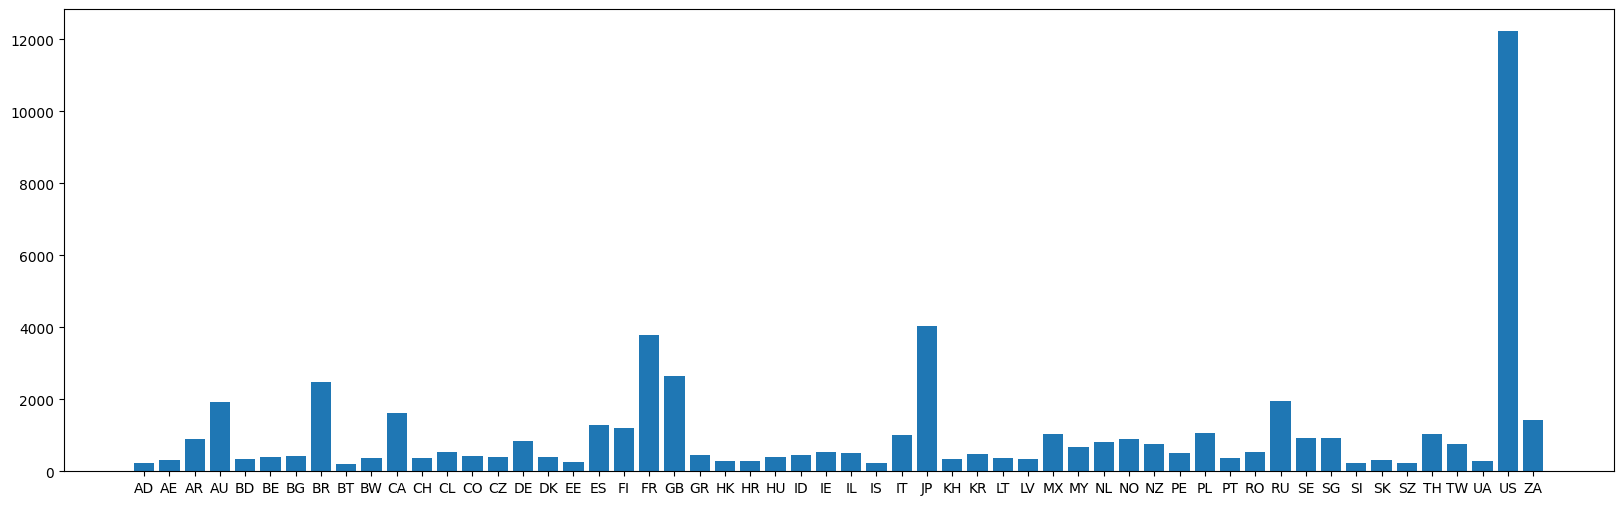

In [ ]:
d = dict(zip(country_codes.values(), l))
plt.figure(figsize=(20,6))
plt.bar(cntry_str, l, )

In [271]:
romai = ImageGrab.grab() # Image.open("testimage.png")
tr = transforms.Compose([transforms.RandomCrop((512, 1187)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
romai_tr = tr(romai).to(device)
with torch.no_grad():
    guess = F.softmax(dim=1, input=model(romai_tr[None, :]))
print(country_codes[cntry_str[torch.argmax(guess)]])
romai.close()

Netherlands


In [ ]:
while True:
    screen = ImageGrab.grab()
    tr = transforms.Compose([transforms.CenterCrop((800,1800)), transforms.Resize((512, 1187)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    screen_tr = tr(screen).to(device)
    with torch.no_grad():
        guess = F.softmax(dim=1, input=model(screen_tr[None, :]))
    print(f'Guess: {country_codes[cntry_str[torch.argmax(guess)]]} {torch.max(guess)*100:.1f}%  --  Hungary: {guess[0,25]*100:.1f}%')
    #plt.imshow(screen_tr.to('cpu').transpose(0,2).transpose(0,1) *0.5 + 0.5); break
    time.sleep(2)

In [ ]:
plt.imshow(romai_tr.to('cpu').transpose(0,2).transpose(0,1) *0.5 + 0.5)
plt.figure(figsize=(20,6))
plt.bar(cntry_str, guess.to('cpu')[0], )